In [86]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [87]:
df = pd.read_csv('./csv/data/_fixed_train_data.csv')
df = df.drop(['screen_height', 'screen_width'], axis=1)

In [88]:
df.shape

(100, 6)

In [89]:
df.head()

,left_iris_x,left_iris_y,right_iris_x,right_iris_y,point_x,point_y
0,982.150818,228.646149,844.810059,213.429535,50,50
1,988.651672,220.569809,848.104004,207.040283,50,50
2,982.516785,223.811356,842.443604,209.710800,50,50
3,978.285889,224.193680,836.803589,210.543854,50,50
4,972.501831,225.457794,830.710510,212.738846,50,50


In [90]:
df.describe()

,left_iris_x,left_iris_y,right_iris_x,right_iris_y,point_x,point_y
count,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000
mean,750.960868,281.649330,609.265879,286.484865,720.00000,381.000000
std,192.643337,52.792973,193.307124,53.871203,602.28521,297.546873
min,467.904510,194.383514,316.951599,191.025391,50.00000,50.000000
25%,575.448105,226.967823,440.392029,234.631599,50.00000,50.000000
50%,716.225647,285.827988,567.436371,287.910248,720.00000,381.000000
75%,958.926498,324.684441,819.085220,344.132507,1390.00000,712.000000
max,988.651672,362.459869,848.104004,356.346405,1390.00000,712.000000


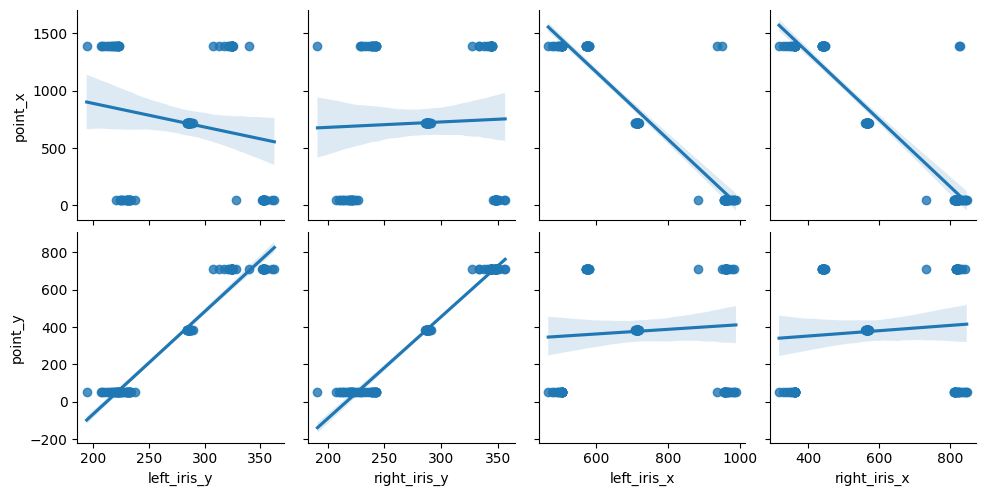

In [91]:
sns.pairplot(df, x_vars=['left_iris_y', 'right_iris_y', 'left_iris_x',
             'right_iris_x'], y_vars=['point_x', 'point_y'], kind='reg')
plt.show()

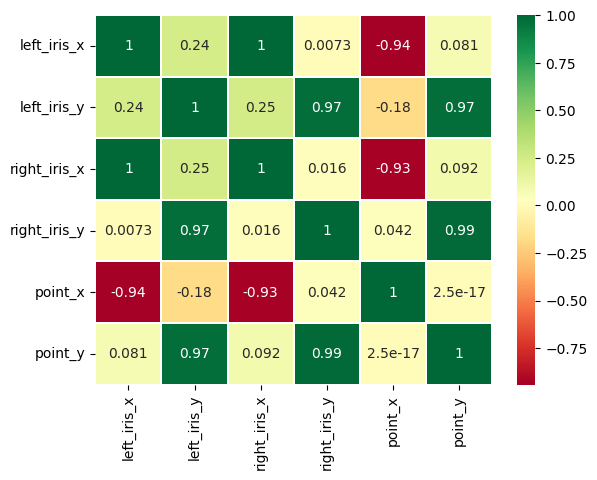

In [92]:
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
plt.show()

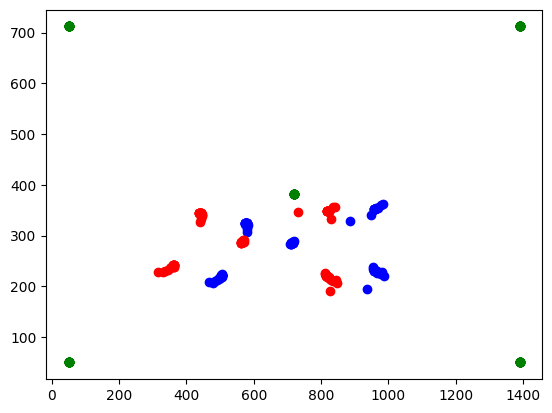

In [93]:
#plot eyes point
plt.scatter(df['left_iris_x'], df['left_iris_y'], color='blue')
plt.scatter(df['right_iris_x'], df['right_iris_y'], color='red')
plt.scatter(df['point_x'], df['point_y'], color='green')
plt.show()

In [94]:
X_x = df[['left_iris_x', 'right_iris_x']]
y_x = df['point_x']

In [95]:
sc = StandardScaler()
X_x = sc.fit_transform(X_x)

In [96]:
X_x[:5]

array([[1.206139  , 1.22463571],
       [1.24005455, 1.24176152],
       [1.20804828, 1.2123321 ],
       [1.18597531, 1.18300867],
       [1.15579936, 1.15132968]])

In [97]:
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(X_x, y_x, test_size=0.2, random_state=42)

In [98]:
model_x = linear_model.LinearRegression()
model_x.fit(X_train_x, y_train_x)
y_pred_x = model_x.predict(X_test_x)
r2_score(y_test_x, y_pred_x)

0.9302680792258697

In [99]:
y_pred_x

array([1429.49894205,  680.57172673,  131.44231077,  669.00439039,
        631.8111595 , 1389.14914482, 1316.88604116,  703.88806421,
         65.96697918,  132.24055415,   65.74068427, 1408.06578184,
        146.5984717 , 1398.73263649, 1443.27119029,   40.93833819,
        122.82860033,  133.60615817,   60.54549706, 1435.09354324])

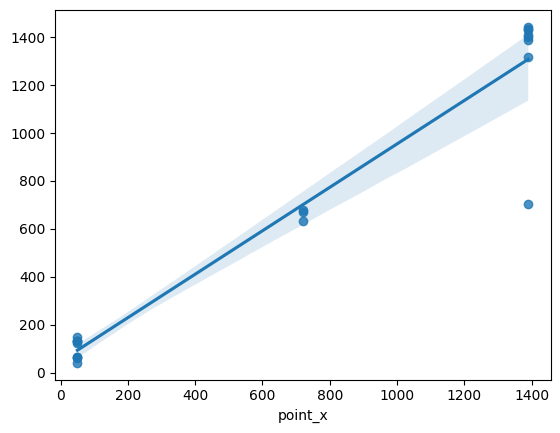

In [100]:
sns.regplot(x=y_test_x, y=y_pred_x)
plt.show()

In [101]:
X_y = df[['left_iris_y', 'right_iris_y']]
y_y = df['point_y']

In [102]:
X_train_y, X_test_y, y_train_y, y_test_y = train_test_split(X_y, y_y, test_size=0.2, random_state=42)

In [103]:
model = linear_model.LinearRegression()
model.fit(X_train_y, y_train_y)
y_pred_y = model.predict(X_test_y)
r2_score(y_test_y, y_pred_y)

0.9822969439315303

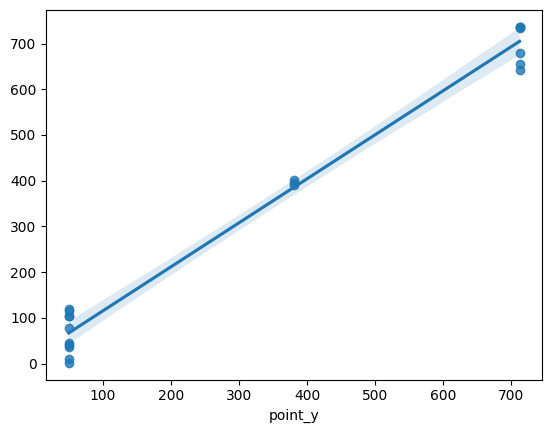

In [104]:
sns.regplot(x=y_test_y, y=y_pred_y)
plt.show()

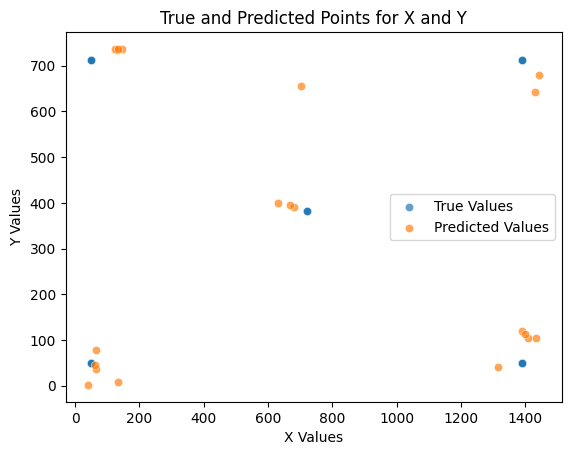

In [105]:
data = {'True X': y_test_x, 'Predicted X': y_pred_x,
        'True Y': y_test_y, 'Predicted Y': y_pred_y}

sns.scatterplot(x='True X', y='True Y', data=data,
                label='True Values', alpha=0.7)
sns.scatterplot(x='Predicted X', y='Predicted Y', data=data,
                label='Predicted Values', alpha=0.7)

plt.title('True and Predicted Points for X and Y')
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.legend()

plt.show()

In [107]:
data = np.array([y_pred_x, y_pred_y]).T

In [108]:
data.shape

(20, 2)

In [109]:
model = KMeans(n_clusters=5, n_init='auto', init='k-means++', random_state=42)
y_kmeans = model.fit_predict(data)

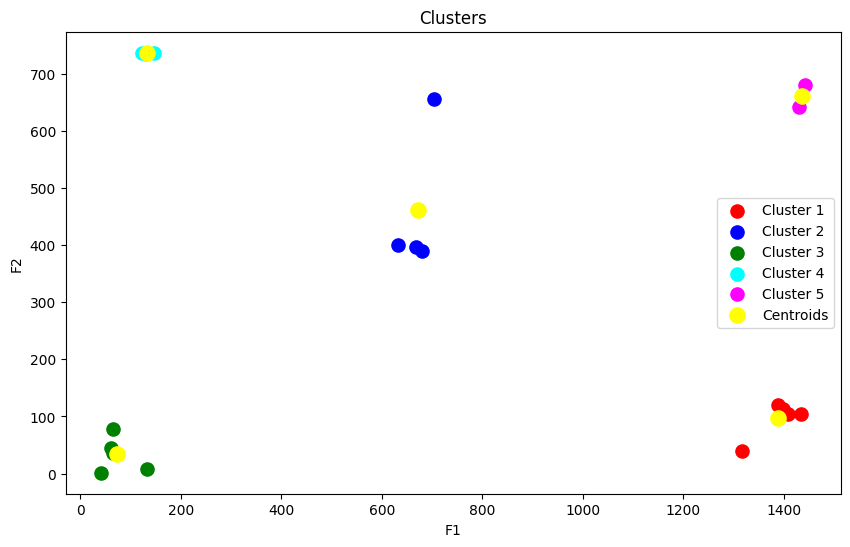

In [110]:
plt.figure(figsize=(10, 6))

plt.scatter(data[y_kmeans == 0, 0], data[y_kmeans == 0, 1],
            s=90, c='red', label='Cluster 1')
plt.scatter(data[y_kmeans == 1, 0], data[y_kmeans == 1, 1],
            s=90, c='blue', label='Cluster 2')
plt.scatter(data[y_kmeans == 2, 0], data[y_kmeans == 2, 1],
            s=90, c='green', label='Cluster 3')
plt.scatter(data[y_kmeans == 3, 0], data[y_kmeans == 3, 1],
            s=90, c='cyan', label='Cluster 4')
plt.scatter(data[y_kmeans == 4, 0], data[y_kmeans == 4, 1],
            s=90, c='magenta', label='Cluster 5')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[
            :, 1], s=120, c='yellow', label='Centroids')

plt.title('Clusters')

plt.xlabel('F1')
plt.ylabel('F2')

plt.legend()

plt.show()

### -------- teste --------

In [314]:
def plot(ax, y_test_x, y_pred_x, y_test_y, y_pred_y, title=None):

    y_test_x = np.array(y_test_x)
    y_test_y = np.array(y_test_y)

    true_points = [(y_test_x[i], y_test_y[i]) for i in range(len(y_test_x))]

    error_range = 0.05

    data = {'True X': y_test_x, 'Predicted X': y_pred_x,
            'True Y': y_test_y, 'Predicted Y': y_pred_y}

    sns.scatterplot(x='True X', y='True Y', data=data,
                    label='True Values', alpha=0.7, ax=ax, color='red')
    sns.scatterplot(x='Predicted X', y='Predicted Y', data=data,
                    label='Predicted Values', alpha=0.7, ax=ax, color='green')

    circle_radius = error_range * (max(y_test_x) - min(y_test_x)
                                   + max(y_test_y) - min(y_test_y)) / 2

    for true_x, true_y in true_points:

        x_within_range = [y_pred_x[j] for j in range(len(y_test_x)) if abs(
            y_test_x[j] - true_x) <= error_range]
        y_within_range = [y_pred_y[j] for j in range(len(y_test_y)) if abs(
            y_test_y[j] - true_y) <= error_range]

        if len(x_within_range) > 1 and len(y_within_range) > 1:

            combined_predictions = x_within_range + y_within_range
            true_values = [true_x] * len(x_within_range) + \
                [true_y] * len(y_within_range)

            r2_combined = r2_score(true_values, combined_predictions)
            mae_combined = mean_absolute_error(
                true_values, combined_predictions)

            circle = plt.Circle((true_x, true_y), circle_radius,
                                color='yellow', fill=False)
            ax.add_patch(circle)

            ax.text(true_x + 0.1, true_y + 0.1, f'R2={r2_combined:.2f}\nMAE={mae_combined:.2f}',
                    fontsize=8, color='blue')

    title = title if title else 'True and Predicted Points for X and Y'
    ax.set_title(title)
    ax.legend()

In [315]:
def analysis(df, ax=None, title=None):

    # x
    X_x = df[['left_iris_x', 'right_iris_x']]
    X_y = df['point_x']

    sc = StandardScaler()
    X_x = sc.fit_transform(X_x)

    X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(
        X_x, X_y, test_size=0.2, random_state=42)

    model = linear_model.LinearRegression()
    model.fit(X_train_x, y_train_x)
    y_pred_x = model.predict(X_test_x)
    r2_score(y_test_x, y_pred_x)

    # y
    X_y = df[['left_iris_y', 'right_iris_y']]
    y_y = df['point_y']

    sc = StandardScaler()
    X_y = sc.fit_transform(X_y)

    X_train_y, X_test_y, y_train_y, y_test_y = train_test_split(
        X_y, y_y, test_size=0.2, random_state=42)

    model = linear_model.LinearRegression()
    model.fit(X_train_y, y_train_y)
    y_pred_y = model.predict(X_test_y)
    r2_score(y_test_y, y_pred_y)

    plot(ax, y_test_x, y_pred_x, y_test_y, y_pred_y, title)

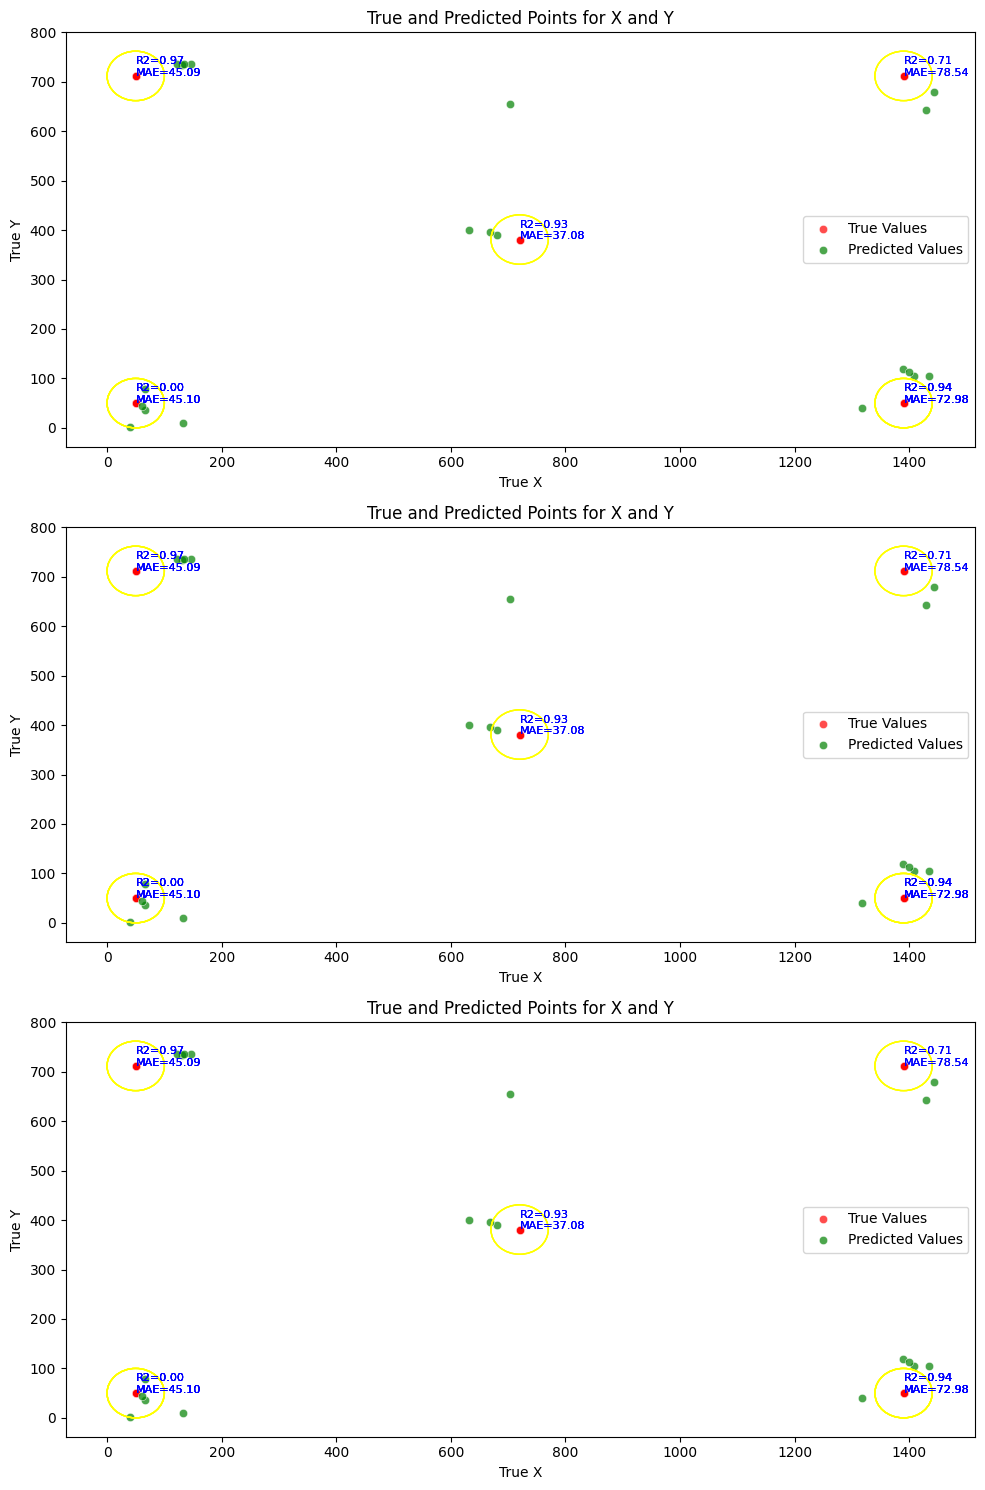

In [317]:
df = pd.read_csv('./csv/data/_fixed_train_data.csv')
df = df.drop(['screen_height', 'screen_width'], axis=1)

df_list = [df, df, df]

# num_rows = len(df_list) // 2 + len(df_list) % 2
# num_cols = min(2, len(df_list))

num_rows = len(df_list)
num_cols = 1

fig_height = 5 * num_rows
fig, axes = plt.subplots(
    num_rows, num_cols, figsize=(10, fig_height), squeeze=False)

for i, df in enumerate(df_list):

    # row_idx = i // num_cols
    # col_idx = i % num_cols

    row_idx = i
    col_idx = 0

    ax = axes[row_idx, col_idx]
    analysis(df, ax)

plt.tight_layout()
plt.show()